# Dimensionality Reduction using PCA and t-SNE

***

The goals of this notebook are to explore techniques for reducing the dimensions of our multivariate time series while retaining the most information. We will focus on two techniques that could be scaled to deal with high dimensional spatial data. These techniques are **principal component analysis (PCA)** and **t-distributed stochastic neighbor embedding (t-SNE)**. 

<font color=blue>Datasets:</font> The data consists of 5 time series variables (described below) from the North Pacific at 30n120w, 30n140w, 40n160w, and 50n140w. 

- [NOAA's Optimum Interpolation Sea Surface Temperature](https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oisst.v2.highres.html) dataset consists of daily sea surface temperature measurements (ºC) from 1981-09-01 to 2018-06-11. We will be using four time series in the eastern North Pacific.
- [NCEP/NCAR Reanalysis 1](https://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis.surface.html) consists of daily atmospheric surface air tempertaure (ºC), relative humidity (%), wind speed (m/s) and sea level pressure (mb) on a global grid from 1948 to present. 
***

<font color=blue>Creator:</font> Hillary Scannell, University of Washington, scanh@uw.edu

<font color=blue>Created:</font> 2018-07-18

***

In [1]:
# Import Python Libraries
import numpy as np
import os, time, datetime
from datetime import date
import pandas as pd
from pandas import DataFrame, Series, concat
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import time

#### Import data into a pandas dataframe
There are four time series of sea surface temperature (SST) contained in seperate netCDF files. The code below extracts the data from the data files using the indexing parameter *f*. Change the path (*fp*) to match the file directory on your machine and choose *f* values from 0 to 3 to change files. 

In [2]:
files = ['30n120w.nc', '30n140w.nc', '40n160w.nc', '50n140w.nc'] 
f = 0 # index to files  <- choose to analyze a different time series by changing f from 0 to 3

lat = files[f][0:2]
lon = files[f][3:6]
print('Location: '+lat+'ºN,'+lon+'ºS')

Location: 30ºN,120ºS


In [3]:
fp = '/Users/hscannell/Desktop/data/SST_daily_time_series/' # <- change this to your path

# SEA SURFACE TEMPERATURE
data_files = Dataset(fp+'sst_'+files[f]) # reading the netCDF file and creating a dataset 
SST = np.squeeze(data_files.variables['sst'][:])
f_time = data_files.variables['time'][:] # time is given in days since 1800-01-01 00:00:00
ref = datetime.date(1800, 1, 1).toordinal()
sst_time = ref+f_time # adjust time as days since 0000-01-01 00:00:00
sst_dates = [date.fromordinal(tt.astype(int)) for tt in sst_time]
sst_dates = np.array(sst_dates)
sst = pd.Series(SST)

fp = '/Users/hscannell/Desktop/data/NCEP/ftp.cdc.noaa.gov/Datasets/ncep_timeseries/'

# AIR TEMPERATURE
data_files = Dataset(fp+'airt_'+files[f]) 
airt = np.squeeze(data_files.variables['air'][:])
airt = airt-273.15 # Kelvin to Celsius
# Time (days since). Do this once because all atmospheric variables have the same time 
f_time = data_files.variables['time'][:] # time is given in days since 1-1-1 00:00:0.0
ref = datetime.date(1, 1, 1).toordinal()
atmo_time = ref+f_time # adjust time as days since 0000-01-01 00:00:00
ind0 = int(np.where(atmo_time==sst_time[0])[0]) # Index into the atmospheric data where it aligns with the SST data
ind00 = int(np.where(atmo_time==sst_time[-1])[0])
atmo_dates = [date.fromordinal(tt.astype(int)) for tt in atmo_time]
atmo_dates = np.array(atmo_dates[ind0:ind00+1])
atmo_time = np.array(atmo_time[ind0:ind00+1])
# Create a python series
airt = pd.Series(airt[ind0:ind00+1])

# RELATIVE HUMIDITY
data_files = Dataset(fp+'rhum_'+files[f]) 
rhum = np.squeeze(data_files.variables['rhum'][:])
rhum = pd.Series(rhum[ind0:ind00+1])

# SEA LEVEL PRESSURE
data_files = Dataset(fp+'slp_'+files[f]) 
slp = np.squeeze(data_files.variables['slp'][:])
slp = pd.Series(slp[ind0:ind00+1])

# WIND SPEED
data_files = Dataset(fp+'uwnd_'+files[f]) 
uwnd = np.squeeze(data_files.variables['uwnd'][:])
data_files = Dataset(fp+'vwnd_'+files[f]) 
vwnd = np.squeeze(data_files.variables['vwnd'][:])
transform_wind = np.sqrt(np.square(uwnd)+np.square(vwnd))
ws = pd.Series(transform_wind[ind0:ind00+1])

data = DataFrame(np.transpose(np.array([sst, airt, rhum, slp, ws])), columns=['SST','AirT','RH','SLP','WS'])
dates = atmo_dates
print('Shape of Data and Dates =', data.shape, dates.shape)

Shape of Data and Dates = (13433, 5) (13433,)


### Deal with missing values
Linearly interpolate missing values

In [4]:
# search for missing values
values = data.values
values = values.astype('float32')
null_data = data[data.isnull().any(axis=1)]
print('Missing values: ', null_data.shape)
print(null_data)
print('')

missing = np.any(np.isnan(values))
finite = np.all(np.isfinite(values)) # determines whether the passed value is a finite number. 
print('Are there missing values in my data?..', missing)
print('Are my values finite?..', finite)

# linearly interpolate missing values column wise
interpval = data.interpolate(method='linear', axis=0, limit=5) 

null_data_ind = null_data.index.tolist()
print('Interpolated Values:')
print(interpval.iloc[null_data_ind])

# Update data with interpolated values
data = interpval

Missing values:  (2, 5)
        SST       AirT     RH          SLP        WS
7693  18.85  20.250000  37.75  1013.490051       NaN
9032  16.66  16.559998    NaN  1015.000000  3.939531

Are there missing values in my data?.. True
Are my values finite?.. False
Interpolated Values:
        SST       AirT     RH          SLP        WS
7693  18.85  20.250000  37.75  1013.490051  6.372299
9032  16.66  16.559998  74.75  1015.000000  3.939531


#### Plot time series

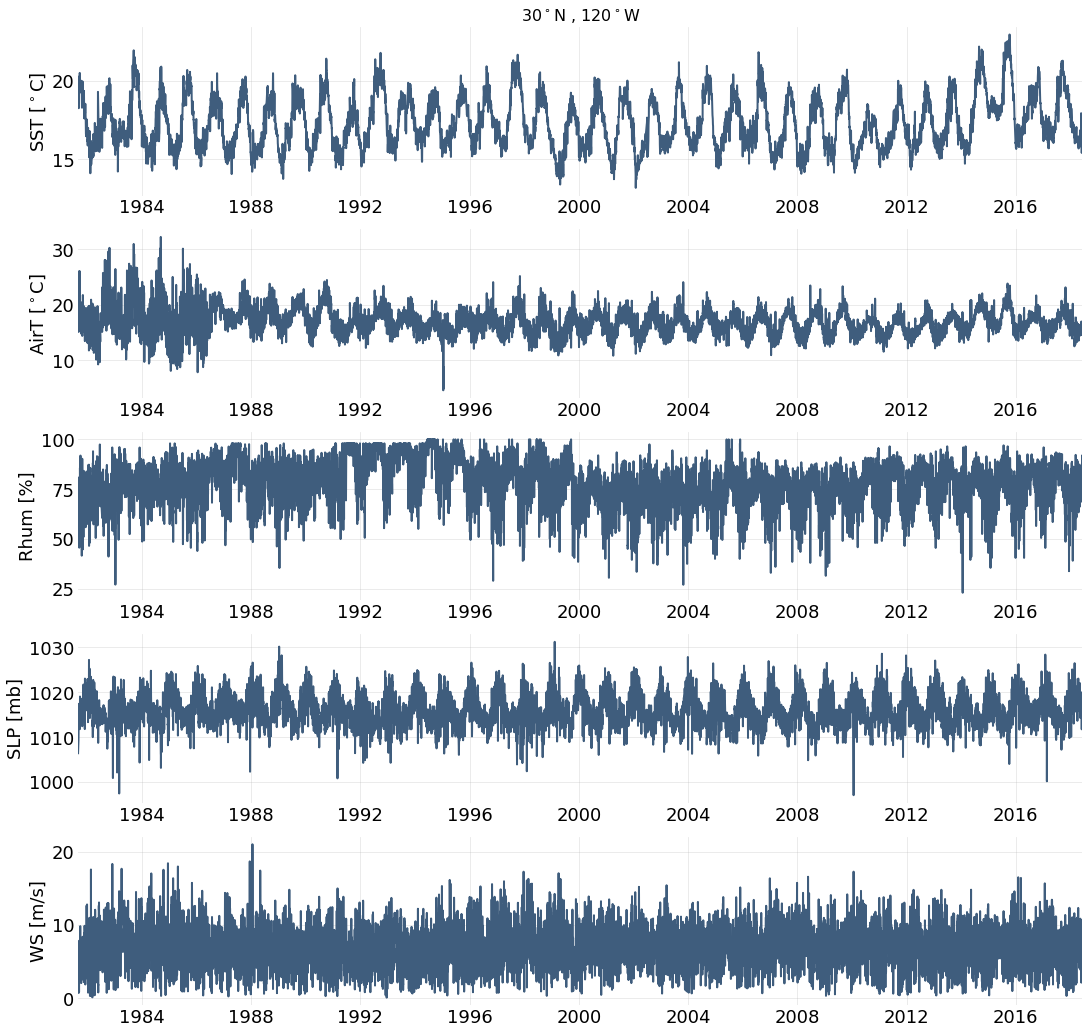

In [5]:
# Plot Time Series
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18)
plt.figure(figsize=(18, 18))

# SST
ax = plt.subplot(511)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)  
ax.spines["left"].set_visible(False)  
ax.tick_params(axis=u'both', which=u'both', length=0)
plt.plot(dates, data['SST'], color="#3F5D7D", linewidth = 2)
plt.ylabel('SST [$^\circ$C]', size=18)
plt.xlim(dates[0], dates[-1])
plt.grid(True, alpha=0.3)
plt.title(lat + '$^\circ$N , ' + lon +'$^\circ$W', fontsize=16)

# Air Temperature
ax = plt.subplot(512)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)  
ax.spines["left"].set_visible(False)  
ax.tick_params(axis=u'both', which=u'both', length=0)
plt.plot(dates, data['AirT'], color="#3F5D7D", linewidth = 2)
plt.ylabel('AirT [$^\circ$C]', size=18)
plt.xlim(dates[0], dates[-1])
plt.grid(True, alpha=0.3)

# Relative Humidity
ax = plt.subplot(513)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)  
ax.spines["left"].set_visible(False)  
ax.tick_params(axis=u'both', which=u'both', length=0)
plt.plot(dates, data['RH'], color="#3F5D7D", linewidth = 2)
plt.ylabel('Rhum [%]', size=18)
plt.xlim(dates[0], dates[-1])
plt.grid(True, alpha=0.3)

# Sea Level Pressure
ax = plt.subplot(514)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)  
ax.spines["left"].set_visible(False)  
ax.tick_params(axis=u'both', which=u'both', length=0)
plt.plot(dates, data['SLP'], color="#3F5D7D", linewidth = 2)
plt.ylabel('SLP [mb]', size=18)
plt.xlim(dates[0], dates[-1])
plt.grid(True, alpha=0.3)

# Wind Speed
ax = plt.subplot(515)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)  
ax.spines["left"].set_visible(False)  
ax.tick_params(axis=u'both', which=u'both', length=0)
plt.plot(dates, data['WS'], color="#3F5D7D", linewidth = 2)
plt.ylabel('WS [m/s]', size=18)
plt.xlim(dates[0], dates[-1])
plt.grid(True, alpha=0.3)

We have 5 features (SST, AirT, RH, SLP, and WS), so 5 dimensions and 13433 time steps. 

#### Normalize  data

mean: 
SST     0.000025
AirT    0.000014
RH     -0.000006
SLP    -0.000572
WS     -0.000002
dtype: float32 

standard deviation: 
SST     0.999995
AirT    1.000001
RH      0.999992
SLP     1.000000
WS      1.000001
dtype: float32


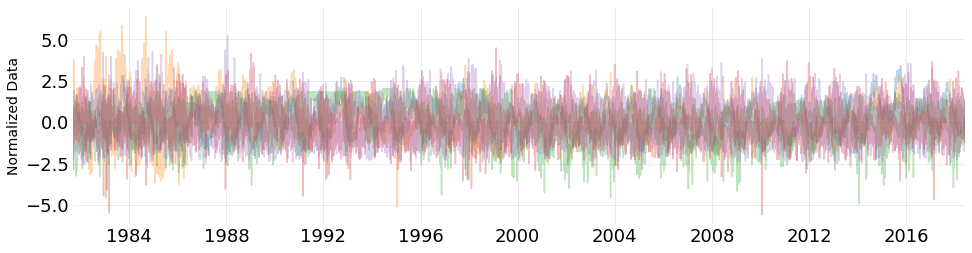

In [27]:
# Normalize data
#data_normalized = (data.values - data.values.mean(axis=0)) / data.values.std(axis=0)
data_normalized = (data - data.mean(axis=0)) / data.std(axis=0)

plt.figure(figsize=(16,4))
ax = plt.subplot(111)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)  
ax.spines["left"].set_visible(False)  
ax.tick_params(axis=u'both', which=u'both', length=0)
plt.plot(dates, data_normalized, alpha=0.3);
plt.ylabel('Normalized Data', fontsize=14)
plt.xlim(dates[0], dates[-1])
plt.grid(True, alpha=0.3);

print('mean: \n{} \n\nstandard deviation: \n{}'.format(data_normalized.mean(axis=0), data_normalized.std(axis=0)))

## PCA

Explained variation per principal component: 
[0.40036714 0.22775526 0.19067964 0.11068906 0.07050893]


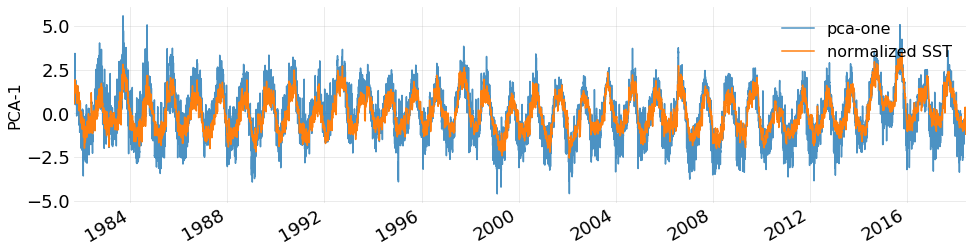

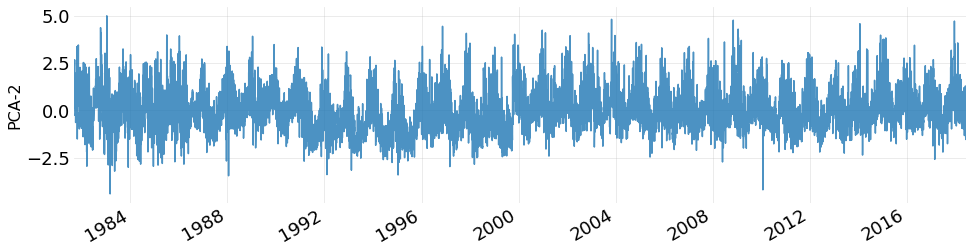

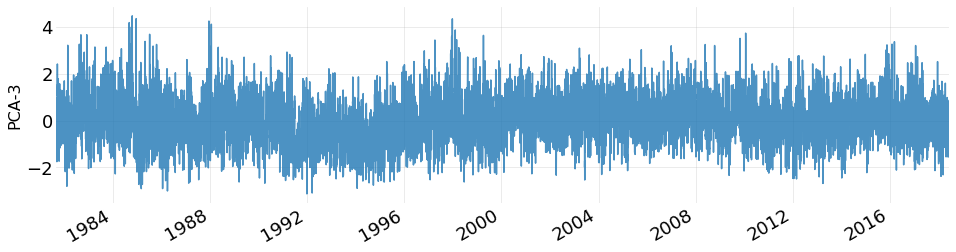

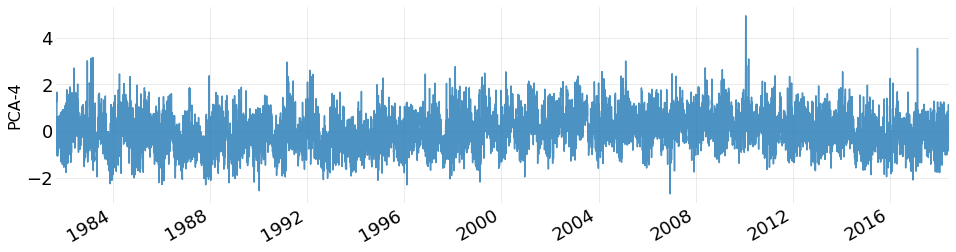

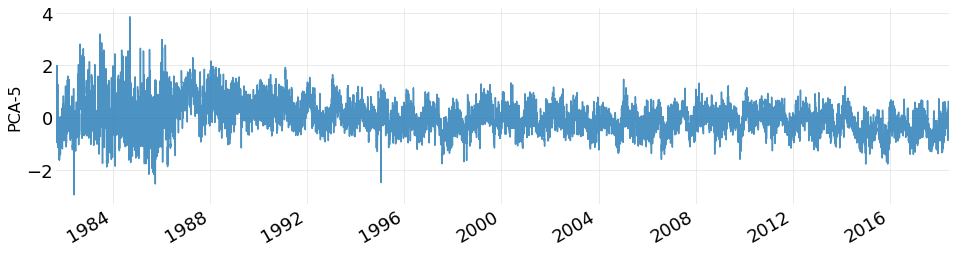

In [36]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
pca_result = pca.fit_transform(data_normalized.values[:,0:5]) # first four features (SST, AirT, RH, SLP, WS)

data_normalized['pca-one'] = pca_result[:,0]
data_normalized['pca-two'] = pca_result[:,1] 
data_normalized['pca-three'] = pca_result[:,2]
data_normalized['pca-four'] = pca_result[:,3]
data_normalized['pca-five'] = pca_result[:,4]

print('Explained variation per principal component: \n{}'.format(pca.explained_variance_ratio_))

plt.figure(figsize=(16,4))
ax = plt.subplot(111)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)  
ax.spines["left"].set_visible(False)  
ax.tick_params(axis=u'both', which=u'both', length=0)
plt.plot(dates, data_normalized['pca-one'], alpha=0.8)
plt.plot(dates,data_normalized['SST'], label='normalized SST')
plt.legend(loc="upper right", fontsize=16, frameon=False)
plt.ylabel('PCA-1', fontsize=16)
plt.xlim(dates[0], dates[-1])
plt.grid(True, alpha=0.3)
plt.gcf().autofmt_xdate()

plt.figure(figsize=(16,4))
ax = plt.subplot(111)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)  
ax.spines["left"].set_visible(False)  
ax.tick_params(axis=u'both', which=u'both', length=0)
plt.plot(dates, data_normalized['pca-two'], alpha=0.8)
plt.ylabel('PCA-2', fontsize=16)
plt.xlim(dates[0], dates[-1])
plt.grid(True, alpha=0.3)
plt.gcf().autofmt_xdate()

plt.figure(figsize=(16,4))
ax = plt.subplot(111)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)  
ax.spines["left"].set_visible(False)  
ax.tick_params(axis=u'both', which=u'both', length=0)
plt.plot(dates, data_normalized['pca-three'], alpha=0.8)
plt.ylabel('PCA-3', fontsize=16)
plt.xlim(dates[0], dates[-1])
plt.grid(True, alpha=0.3)
plt.gcf().autofmt_xdate()

plt.figure(figsize=(16,4))
ax = plt.subplot(111)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)  
ax.spines["left"].set_visible(False)  
ax.tick_params(axis=u'both', which=u'both', length=0)
plt.plot(dates, data_normalized['pca-four'], alpha=0.8)
plt.ylabel('PCA-4', fontsize=16)
plt.xlim(dates[0], dates[-1])
plt.grid(True, alpha=0.3)
plt.gcf().autofmt_xdate()

plt.figure(figsize=(16,4))
ax = plt.subplot(111)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)  
ax.spines["left"].set_visible(False)  
ax.tick_params(axis=u'both', which=u'both', length=0)
plt.plot(dates, data_normalized['pca-five'], alpha=0.8)
plt.ylabel('PCA-5', fontsize=16)
plt.xlim(dates[0], dates[-1])
plt.grid(True, alpha=0.3)
plt.gcf().autofmt_xdate()

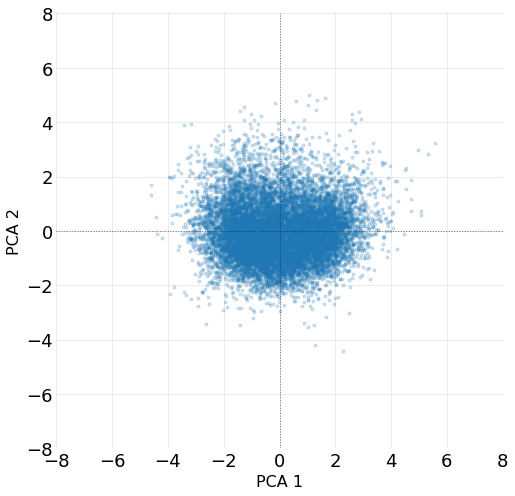

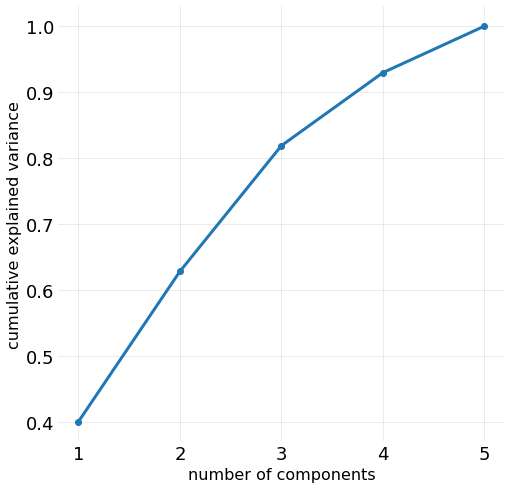

In [8]:
plt.figure(figsize=(8,8))
ax = plt.subplot(111)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)  
ax.spines["left"].set_visible(False)  
ax.tick_params(axis=u'both', which=u'both', length=0)
plt.grid(True, alpha=0.3)
plt.plot(data_normalized['pca-one'],data_normalized['pca-two'],'.',alpha=0.2)
plt.plot([-8,8], [0,0], 'k-', linestyle = ":", lw=1, alpha=0.5)
plt.plot([0,0], [-8,8], 'k-', linestyle = ":", lw=1, alpha=0.5)
plt.xlim(-8, 8); plt.ylim(-8,8)

plt.ylabel('PCA 2', fontsize=16)
plt.xlabel('PCA 1', fontsize=16)

plt.figure(figsize=(8,8))
ax = plt.subplot(111)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)  
ax.spines["left"].set_visible(False)  
ax.tick_params(axis=u'both', which=u'both', length=0)
plt.grid(True, alpha=0.3)
plt.plot(np.arange(1,6,1),np.cumsum(pca.explained_variance_ratio_), 'o-', linewidth=3)
plt.xlabel('number of components', fontsize=16)
plt.ylabel('cumulative explained variance', fontsize=16);

#### Code Guides and Inspiration
https://medium.com/@luckylwk/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b